# Developing an AI application

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smart phone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications. 

In this project, you'll train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice you'd train this classifier, then export it for use in your application. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) of 102 flower categories, you can see a few examples below. 

<img src='assets/Flowers.png' width=500px>

The project is broken down into multiple steps:

* Load and preprocess the image dataset
* Train the image classifier on your dataset
* Use the trained classifier to predict image content

We'll lead you through each part which you'll implement in Python.

When you've completed this project, you'll have an application that can be trained on any set of labeled images. Here your network will be learning about flowers and end up as a command line application. But, what you do with your new skills depends on your imagination and effort in building a dataset. For example, imagine an app where you take a picture of a car, it tells you what the make and model is, then looks up information about it. Go build your own dataset and make something new.

First up is importing the packages you'll need. It's good practice to keep all the imports at the beginning of your code. As you work through this notebook and find you need to import a package, make sure to add the import up here.

In [0]:
# Installing pytorch and torchvision
!pip install torch torchvision pytorch-ignite

In [0]:
!pip install pillow==4.1.1

In [0]:
# downloading the data
!wget https://s3.amazonaws.com/content.udacity-data.com/courses/nd188/flower_data.zip

In [4]:
!ls

flower_data.zip  sample_data


In [0]:
# extracting the data
!unzip -q ./flower_data.zip 

In [0]:
# download flower names
# !wget https://github.com/udacity/pytorch_challenge/blob/master/cat_to_name.json

In [0]:
# !pip install pillow==4.1.1
# %reload_ext autoreload
# %autoreload

In [0]:
# Imports here
import torch
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets,transforms, utils, models
from ignite.engine import Events, Engine, create_supervised_trainer, create_supervised_evaluator
from ignite.metrics import Accuracy, Loss
from ignite import handlers
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import json
import time
import PIL as pil
import copy 
from tqdm import tqdm

In [7]:
print(torch.__version__)

1.0.0


In [0]:
# connect too  Gdrive
from google.colab import drive
drive.mount('gdrive')

## Load the data

Here you'll use `torchvision` to load the data ([documentation](http://pytorch.org/docs/0.3.0/torchvision/index.html)). You can [download the data here](https://s3.amazonaws.com/content.udacity-data.com/courses/nd188/flower_data.zip). The dataset is split into two parts, training and validation. For the training, you'll want to apply transformations such as random scaling, cropping, and flipping. This will help the network generalize leading to better performance. If you use a pre-trained network, you'll also need to make sure the input data is resized to 224x224 pixels as required by the networks.

The validation set is used to measure the model's performance on data it hasn't seen yet. For this you don't want any scaling or rotation transformations, but you'll need to resize then crop the images to the appropriate size.

The pre-trained networks available from `torchvision` were trained on the ImageNet dataset where each color channel was normalized separately. For both sets you'll need to normalize the means and standard deviations of the images to what the network expects. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`, calculated from the ImageNet images.  These values will shift each color channel to be centered at 0 and range from -1 to 1.

In [0]:
data_dir = './flower_data'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'

In [0]:
data_count_train = [(str(i), len(glob.glob(train_dir+'/{}/'.format(i)+'*.*'))) for i in range(1, 103)]
lab, counts = [item[0] for item in data_count_train], [item[1] for item in data_count_train]

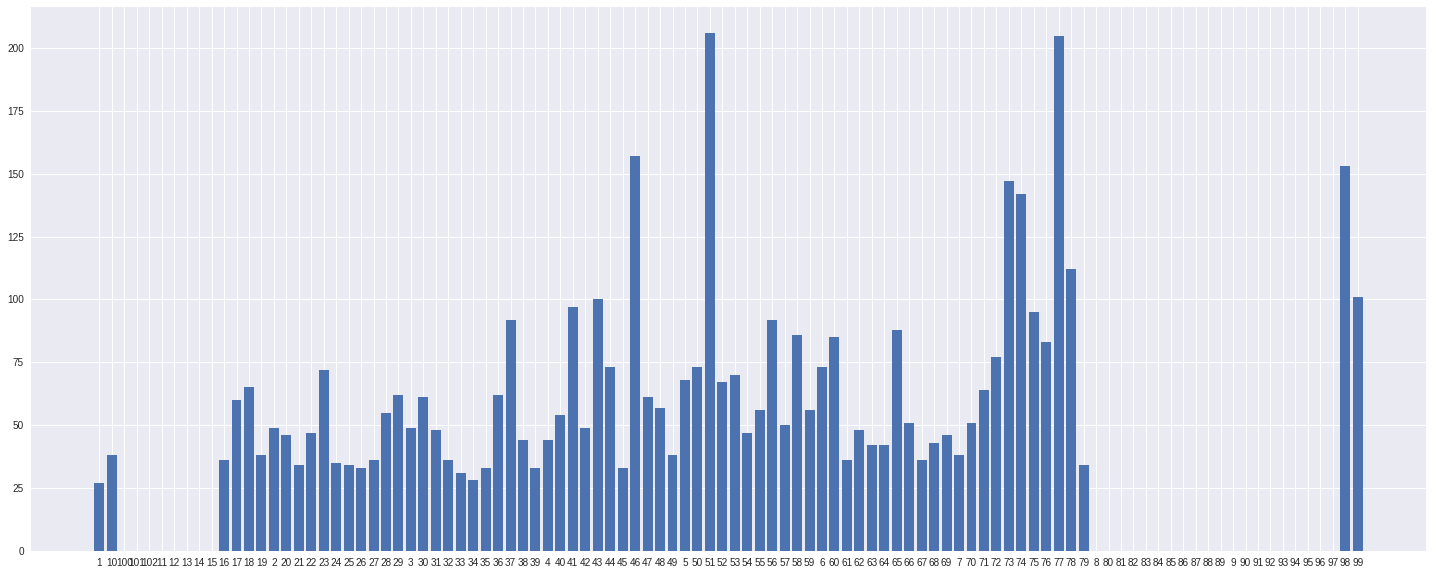

In [11]:
plt.figure(figsize=(25, 10))
plt.bar(lab, counts)
plt.show()

In [12]:
min(counts), max(counts)

(27, 206)

In [0]:
data_count_val = [(str(i), len(glob.glob(valid_dir+'/{}/'.format(i)+'*.*'))) for i in range(1, 103)]
lab, counts = [item[0] for item in data_count_val], [item[1] for item in data_count_val]

In [14]:
min(counts), max(counts)

(1, 28)

In [0]:
# TODO: Define your transforms for the training and validation sets
input_size = 224
batch_size = 64

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
#         transforms.RandomRotation(15),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}


# TODO: Load the datasets with ImageFolder
image_datasets = {
    x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
    for x in ['train', 'valid']
}

# TODO: Using the image datasets and the trainforms, define the dataloaders
dataloaders = {
    x: DataLoader(image_datasets[x], batch_size=batch_size, num_workers=4, shuffle=True)
    for x in ['train', 'valid']
}

dataset_sizes = {phase: len(dataloaders[phase].dataset) for phase in ['train', 'valid']}

In [16]:
dataset_sizes

{'train': 6552, 'valid': 818}

### Label mapping

You'll also need to load in a mapping from category label to category name. You can find this in the file `cat_to_name.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/2/library/json.html). This will give you a dictionary mapping the integer encoded categories to the actual names of the flowers.

In [0]:
# with open('./cat_to_name.json', 'r') as f:
#     cat_to_name = json.load(f)
cat_to_name = {"21": "fire lily", "3": "canterbury bells", "45": "bolero deep blue", "1": "pink primrose",
               "34": "mexican aster", "27": "prince of wales feathers", "7": "moon orchid", "16": "globe-flower",
               "25": "grape hyacinth", "26": "corn poppy", "79": "toad lily", "39": "siam tulip", "24": "red ginger",
               "67": "spring crocus", "35": "alpine sea holly", "32": "garden phlox", "10": "globe thistle",
               "6": "tiger lily", "93": "ball moss", "33": "love in the mist", "9": "monkshood", "102": "blackberry lily",
               "14": "spear thistle", "19": "balloon flower", "100": "blanket flower", "13": "king protea", "49": "oxeye daisy",
               "15": "yellow iris", "61": "cautleya spicata", "31": "carnation", "64": "silverbush", "68": "bearded iris",
               "63": "black-eyed susan", "69": "windflower", "62": "japanese anemone", "20": "giant white arum lily", "38": "great masterwort",
               "4": "sweet pea", "86": "tree mallow", "101": "trumpet creeper", "42": "daffodil", "22": "pincushion flower",
               "2": "hard-leaved pocket orchid", "54": "sunflower", "66": "osteospermum", "70": "tree poppy", "85": "desert-rose",
               "99": "bromelia", "87": "magnolia", "5": "english marigold", "92": "bee balm", "28": "stemless gentian",
               "97": "mallow", "57": "gaura", "40": "lenten rose", "47": "marigold", "59": "orange dahlia", "48": "buttercup",
               "55": "pelargonium", "36": "ruby-lipped cattleya", "91": "hippeastrum", "29": "artichoke", "71": "gazania", "90": "canna lily",
               "18": "peruvian lily", "98": "mexican petunia", "8": "bird of paradise", "30": "sweet william", "17": "purple coneflower",
               "52": "wild pansy", "84": "columbine", "12": "colt's foot", "11": "snapdragon", "96": "camellia", "23": "fritillary",
               "50": "common dandelion", "44": "poinsettia", "53": "primula", "72": "azalea", "65": "californian poppy", "80": "anthurium",
               "76": "morning glory", "37": "cape flower", "56": "bishop of llandaff", "60": "pink-yellow dahlia", "82": "clematis",
               "58": "geranium", "75": "thorn apple", "41": "barbeton daisy", "95": "bougainvillea", "43": "sword lily", "83": "hibiscus",
               "78": "lotus lotus", "88": "cyclamen", "94": "foxglove", "81": "frangipani", "74": "rose", "89": "watercress", "73": "water lily",
               "46": "wallflower", "77": "passion flower", "51": "petunia"}

In [0]:
len(cat_to_name)

102

In [0]:
sorted(cat_to_name.keys())

# Building and training the classifier

Now that the data is ready, it's time to build and train the classifier. As usual, you should use one of the pretrained models from `torchvision.models` to get the image features. Build and train a new feed-forward classifier using those features.

We're going to leave this part up to you. If you want to talk through it with someone, chat with your fellow students! You can also ask questions on the forums or join the instructors in office hours.

Refer to [the rubric](https://review.udacity.com/#!/rubrics/1663/view) for guidance on successfully completing this section. Things you'll need to do:

* Load a [pre-trained network](http://pytorch.org/docs/master/torchvision/models.html) (If you need a starting point, the VGG networks work great and are straightforward to use)
* Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout
* Train the classifier layers using backpropagation using the pre-trained network to get the features
* Track the loss and accuracy on the validation set to determine the best hyperparameters

We've left a cell open for you below, but use as many as you need. Our advice is to break the problem up into smaller parts you can run separately. Check that each part is doing what you expect, then move on to the next. You'll likely find that as you work through each part, you'll need to go back and modify your previous code. This is totally normal!

When training make sure you're updating only the weights of the feed-forward network. You should be able to get the validation accuracy above 70% if you build everything right. Make sure to try different hyperparameters (learning rate, units in the classifier, epochs, etc) to find the best model. Save those hyperparameters to use as default values in the next part of the project.

In [0]:
# TODO: Build and train your network

def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

def initialize_model(model_name, feature_extract, num_classes=102, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    if model_name == "resnet":
        """ Resnet50
        """
        model_ft = models.resnet34(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "alexnet":
        """ Alexnet
        """
        model_ft = models.alexnet(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "vgg":
        """ VGG11_bn
        """
        model_ft = models.vgg19_bn(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "squeezenet":
        """ Squeezenet
        """
        model_ft = models.squeezenet1_0(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        model_ft.num_classes = num_classes
        input_size = 224

    elif model_name == "densenet":
        """ Densenet
        """
        model_ft = models.densenet121(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "inception":
        """ Inception v3
        Be careful, expects (299,299) sized images and has auxiliary output
        """
        model_ft = models.inception_v3(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        # Handle the auxilary net
        num_ftrs = model_ft.AuxLogits.fc.in_features
        model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
        # Handle the primary net
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs,num_classes)
        input_size = 299

    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft, input_size


In [18]:
# Initialize the model for this run
model_name = 'resnet'
num_classes = 102
feature_extract = False
model_ft, input_size = initialize_model(model_name, feature_extract, num_classes, use_pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.torch/models/resnet34-333f7ec4.pth
100%|██████████| 87306240/87306240 [00:00<00:00, 87538887.89it/s]


In [19]:
print(model_ft)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Co

In [0]:
input_size

224

In [0]:
def run(model, train_batch_size, val_batch_size, epochs, optimizer, log_interval,
        dirname='resnet_models', filename_prefix='resnet', n_saved=2):
    
    train_loader, val_loader = dataloaders['train'], dataloaders['valid']
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#     optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)
    trainer = create_supervised_trainer(model, optimizer, F.cross_entropy, device=device)
    evaluator = create_supervised_evaluator(model,
                                            metrics={'accuracy': Accuracy(),
                                                     'nll': Loss(F.cross_entropy)},
                                            device=device)
    
    
   
    def get_val_loss(engine):
        evaluator.run(val_loader)
        return -evaluator.state.metrics['nll']
    
    checkpointer = handlers.ModelCheckpoint(dirname=dirname, filename_prefix=filename_prefix, 
                                            score_function=get_val_loss,
                                            score_name='val_loss',
                                            n_saved=n_saved, create_dir=True,
                                            require_empty=False
                                           )
        
    trainer.add_event_handler(Events.EPOCH_COMPLETED, checkpointer, 
                              {'optimizer': optimizer, 'model':model})
    
    desc = "ITERATION - loss: {:.3f}"
    pbar = tqdm(
        initial=0, leave=False, total=len(train_loader),
        desc=desc.format(0)
    )

    @trainer.on(Events.ITERATION_COMPLETED)
    def log_training_loss(engine):
        iter_ = (engine.state.iteration - 1) % len(train_loader) + 1

        if iter_ % log_interval == 0:
            pbar.desc = desc.format(engine.state.output)
            pbar.update(log_interval)

    @trainer.on(Events.EPOCH_COMPLETED)
    def log_training_results(engine):
        pbar.refresh()
        evaluator.run(train_loader)
        metrics = evaluator.state.metrics
        avg_accuracy = metrics['accuracy']
        avg_nll = metrics['nll']
        tqdm.write(
            "Training Results - Epoch: {}  Avg accuracy: {:.3f} Avg loss: {:.3f}"
            .format(engine.state.epoch, avg_accuracy, avg_nll)
        )

    @trainer.on(Events.EPOCH_COMPLETED)
    def log_validation_results(engine):
        evaluator.run(val_loader)
        metrics = evaluator.state.metrics
        avg_accuracy = metrics['accuracy']
        avg_nll = metrics['nll']
        tqdm.write(
            "Validation Results - Epoch: {}  Avg accuracy: {:.3f} Avg loss: {:.3f}"
            .format(engine.state.epoch, avg_accuracy, avg_nll))

        pbar.n = pbar.last_print_n = 0
        

    trainer.run(train_loader, max_epochs=epochs)
    pbar.close()

In [0]:
# instantiate optimizer and loss
optimizer = optim.Adam(
    [
        {"params": model_ft.fc.parameters(), "lr": 1e-3},
        {"params": model_ft.conv1.parameters()},
        {"params": model_ft.layer1.parameters()},
        {"params": model_ft.layer2.parameters()},
        {"params": model_ft.layer3.parameters()},
        {"params": model_ft.layer4.parameters()},
    ],
    lr=1e-6,
)

# Hyperparameters 
EPOCHS = 100

In [23]:
run(model_ft, train_batch_size=64, val_batch_size=64, epochs=50, optimizer=optimizer, log_interval=10)

ITERATION - loss: 0.232:  97%|█████████▋| 100/103 [02:35<00:02,  1.24it/s]

Training Results - Epoch: 1  Avg accuracy: 0.944 Avg loss: 0.244


ITERATION - loss: 0.232:  97%|█████████▋| 100/103 [02:45<00:02,  1.24it/s]

Validation Results - Epoch: 1  Avg accuracy: 0.947 Avg loss: 0.203


ITERATION - loss: 0.421:  97%|█████████▋| 100/103 [05:21<00:02,  1.11it/s]

Training Results - Epoch: 2  Avg accuracy: 0.951 Avg loss: 0.222


ITERATION - loss: 0.421:  97%|█████████▋| 100/103 [05:31<00:02,  1.11it/s]

Validation Results - Epoch: 2  Avg accuracy: 0.947 Avg loss: 0.198


ITERATION - loss: 0.201:  97%|█████████▋| 100/103 [08:07<00:02,  1.11it/s]

Training Results - Epoch: 3  Avg accuracy: 0.951 Avg loss: 0.215


ITERATION - loss: 0.201:  97%|█████████▋| 100/103 [08:16<00:02,  1.11it/s]

Validation Results - Epoch: 3  Avg accuracy: 0.954 Avg loss: 0.185


ITERATION - loss: 0.425:  97%|█████████▋| 100/103 [10:52<00:02,  1.11it/s]

Training Results - Epoch: 4  Avg accuracy: 0.955 Avg loss: 0.198


ITERATION - loss: 0.425:  97%|█████████▋| 100/103 [11:02<00:02,  1.11it/s]

Validation Results - Epoch: 4  Avg accuracy: 0.951 Avg loss: 0.185


ITERATION - loss: 0.150:  97%|█████████▋| 100/103 [13:38<00:02,  1.11it/s]

Training Results - Epoch: 5  Avg accuracy: 0.955 Avg loss: 0.194


ITERATION - loss: 0.150:  97%|█████████▋| 100/103 [13:47<00:02,  1.11it/s]

Validation Results - Epoch: 5  Avg accuracy: 0.955 Avg loss: 0.176


ITERATION - loss: 0.202:  97%|█████████▋| 100/103 [16:23<00:02,  1.10it/s]

Training Results - Epoch: 6  Avg accuracy: 0.957 Avg loss: 0.188


ITERATION - loss: 0.202:  97%|█████████▋| 100/103 [16:33<00:02,  1.10it/s]

Validation Results - Epoch: 6  Avg accuracy: 0.952 Avg loss: 0.180


ITERATION - loss: 0.173:  97%|█████████▋| 100/103 [19:09<00:02,  1.11it/s]

Training Results - Epoch: 7  Avg accuracy: 0.951 Avg loss: 0.193


ITERATION - loss: 0.173:  97%|█████████▋| 100/103 [19:18<00:02,  1.11it/s]

Validation Results - Epoch: 7  Avg accuracy: 0.954 Avg loss: 0.171


ITERATION - loss: 0.212:  97%|█████████▋| 100/103 [21:54<00:02,  1.11it/s]

Training Results - Epoch: 8  Avg accuracy: 0.959 Avg loss: 0.173


ITERATION - loss: 0.212:  97%|█████████▋| 100/103 [22:04<00:02,  1.11it/s]

Validation Results - Epoch: 8  Avg accuracy: 0.955 Avg loss: 0.156


ITERATION - loss: 0.204:  97%|█████████▋| 100/103 [24:40<00:02,  1.11it/s]

Training Results - Epoch: 9  Avg accuracy: 0.957 Avg loss: 0.174


ITERATION - loss: 0.204:  97%|█████████▋| 100/103 [24:50<00:02,  1.11it/s]

Validation Results - Epoch: 9  Avg accuracy: 0.951 Avg loss: 0.170


ITERATION - loss: 0.252:  97%|█████████▋| 100/103 [27:26<00:02,  1.11it/s]

Training Results - Epoch: 10  Avg accuracy: 0.959 Avg loss: 0.162


ITERATION - loss: 0.252:  97%|█████████▋| 100/103 [27:36<00:02,  1.11it/s]

Validation Results - Epoch: 10  Avg accuracy: 0.955 Avg loss: 0.156


ITERATION - loss: 0.179:  97%|█████████▋| 100/103 [30:12<00:02,  1.11it/s]

Training Results - Epoch: 11  Avg accuracy: 0.964 Avg loss: 0.156


ITERATION - loss: 0.179:  97%|█████████▋| 100/103 [30:21<00:02,  1.11it/s]

Validation Results - Epoch: 11  Avg accuracy: 0.955 Avg loss: 0.147


ITERATION - loss: 0.499:  97%|█████████▋| 100/103 [32:57<00:02,  1.11it/s]

Training Results - Epoch: 12  Avg accuracy: 0.964 Avg loss: 0.142


ITERATION - loss: 0.499:  97%|█████████▋| 100/103 [33:06<00:02,  1.11it/s]

Validation Results - Epoch: 12  Avg accuracy: 0.954 Avg loss: 0.157


ITERATION - loss: 0.183:  97%|█████████▋| 100/103 [35:41<00:02,  1.11it/s]

Training Results - Epoch: 13  Avg accuracy: 0.959 Avg loss: 0.162


ITERATION - loss: 0.183:  97%|█████████▋| 100/103 [35:50<00:02,  1.11it/s]

Validation Results - Epoch: 13  Avg accuracy: 0.957 Avg loss: 0.159


ITERATION - loss: 0.192:  97%|█████████▋| 100/103 [38:26<00:02,  1.11it/s]

Training Results - Epoch: 14  Avg accuracy: 0.964 Avg loss: 0.146


ITERATION - loss: 0.192:  97%|█████████▋| 100/103 [38:35<00:02,  1.11it/s]

Validation Results - Epoch: 14  Avg accuracy: 0.956 Avg loss: 0.150


ITERATION - loss: 0.101:  97%|█████████▋| 100/103 [41:11<00:02,  1.11it/s]

Training Results - Epoch: 15  Avg accuracy: 0.969 Avg loss: 0.128


ITERATION - loss: 0.101:  97%|█████████▋| 100/103 [41:21<00:02,  1.11it/s]

Validation Results - Epoch: 15  Avg accuracy: 0.963 Avg loss: 0.140


ITERATION - loss: 0.252:  97%|█████████▋| 100/103 [43:57<00:02,  1.10it/s]

Training Results - Epoch: 16  Avg accuracy: 0.965 Avg loss: 0.142


ITERATION - loss: 0.252:  97%|█████████▋| 100/103 [44:06<00:02,  1.10it/s]

Validation Results - Epoch: 16  Avg accuracy: 0.961 Avg loss: 0.143


ITERATION - loss: 0.171:  97%|█████████▋| 100/103 [46:42<00:02,  1.10it/s]

Training Results - Epoch: 17  Avg accuracy: 0.965 Avg loss: 0.140


ITERATION - loss: 0.171:  97%|█████████▋| 100/103 [46:52<00:02,  1.10it/s]

Validation Results - Epoch: 17  Avg accuracy: 0.960 Avg loss: 0.137


ITERATION - loss: 0.166:  97%|█████████▋| 100/103 [49:27<00:02,  1.11it/s]

Training Results - Epoch: 18  Avg accuracy: 0.972 Avg loss: 0.124


ITERATION - loss: 0.166:  97%|█████████▋| 100/103 [49:37<00:02,  1.11it/s]

Validation Results - Epoch: 18  Avg accuracy: 0.958 Avg loss: 0.139


ITERATION - loss: 0.285:  97%|█████████▋| 100/103 [52:12<00:02,  1.11it/s]

Training Results - Epoch: 19  Avg accuracy: 0.967 Avg loss: 0.134


ITERATION - loss: 0.285:  97%|█████████▋| 100/103 [52:22<00:02,  1.11it/s]

Validation Results - Epoch: 19  Avg accuracy: 0.962 Avg loss: 0.138


ITERATION - loss: 0.111:  97%|█████████▋| 100/103 [54:57<00:02,  1.11it/s]

Training Results - Epoch: 20  Avg accuracy: 0.967 Avg loss: 0.125


ITERATION - loss: 0.111:  97%|█████████▋| 100/103 [55:06<00:02,  1.11it/s]

Validation Results - Epoch: 20  Avg accuracy: 0.960 Avg loss: 0.151


ITERATION - loss: 0.192:  97%|█████████▋| 100/103 [57:41<00:02,  1.11it/s]

Training Results - Epoch: 21  Avg accuracy: 0.969 Avg loss: 0.125


ITERATION - loss: 0.192:  97%|█████████▋| 100/103 [57:51<00:02,  1.11it/s]

Validation Results - Epoch: 21  Avg accuracy: 0.967 Avg loss: 0.138


ITERATION - loss: 0.204:  97%|█████████▋| 100/103 [1:00:26<00:02,  1.11it/s]

Training Results - Epoch: 22  Avg accuracy: 0.971 Avg loss: 0.119


ITERATION - loss: 0.204:  97%|█████████▋| 100/103 [1:00:35<00:02,  1.11it/s]

Validation Results - Epoch: 22  Avg accuracy: 0.955 Avg loss: 0.143


ITERATION - loss: 0.071:  97%|█████████▋| 100/103 [1:03:10<00:02,  1.11it/s]

Training Results - Epoch: 23  Avg accuracy: 0.971 Avg loss: 0.117


ITERATION - loss: 0.071:  97%|█████████▋| 100/103 [1:03:19<00:02,  1.11it/s]

Validation Results - Epoch: 23  Avg accuracy: 0.961 Avg loss: 0.147


ITERATION - loss: 0.178:  97%|█████████▋| 100/103 [1:05:55<00:02,  1.11it/s]

Training Results - Epoch: 24  Avg accuracy: 0.970 Avg loss: 0.119


ITERATION - loss: 0.178:  97%|█████████▋| 100/103 [1:06:04<00:02,  1.11it/s]

Validation Results - Epoch: 24  Avg accuracy: 0.957 Avg loss: 0.146


ITERATION - loss: 0.114:  97%|█████████▋| 100/103 [1:08:40<00:02,  1.11it/s]

Training Results - Epoch: 25  Avg accuracy: 0.968 Avg loss: 0.121


ITERATION - loss: 0.114:  97%|█████████▋| 100/103 [1:08:49<00:02,  1.11it/s]

Validation Results - Epoch: 25  Avg accuracy: 0.968 Avg loss: 0.130


ITERATION - loss: 0.135:  97%|█████████▋| 100/103 [1:11:26<00:02,  1.11it/s]

Training Results - Epoch: 26  Avg accuracy: 0.973 Avg loss: 0.105


ITERATION - loss: 0.135:  97%|█████████▋| 100/103 [1:11:35<00:02,  1.11it/s]

Validation Results - Epoch: 26  Avg accuracy: 0.966 Avg loss: 0.131


ITERATION - loss: 0.115:  97%|█████████▋| 100/103 [1:14:11<00:02,  1.10it/s]

Training Results - Epoch: 27  Avg accuracy: 0.972 Avg loss: 0.109


ITERATION - loss: 0.115:  97%|█████████▋| 100/103 [1:14:21<00:02,  1.10it/s]

Validation Results - Epoch: 27  Avg accuracy: 0.967 Avg loss: 0.130


ITERATION - loss: 0.080:  97%|█████████▋| 100/103 [1:16:56<00:02,  1.10it/s]

Training Results - Epoch: 28  Avg accuracy: 0.970 Avg loss: 0.109


ITERATION - loss: 0.080:  97%|█████████▋| 100/103 [1:17:05<00:02,  1.10it/s]

Validation Results - Epoch: 28  Avg accuracy: 0.958 Avg loss: 0.143


ITERATION - loss: 0.093:  97%|█████████▋| 100/103 [1:19:41<00:02,  1.11it/s]

Training Results - Epoch: 29  Avg accuracy: 0.974 Avg loss: 0.098


ITERATION - loss: 0.093:  97%|█████████▋| 100/103 [1:19:51<00:02,  1.11it/s]

Validation Results - Epoch: 29  Avg accuracy: 0.962 Avg loss: 0.134


ITERATION - loss: 0.113:  97%|█████████▋| 100/103 [1:22:27<00:02,  1.11it/s]

Training Results - Epoch: 30  Avg accuracy: 0.974 Avg loss: 0.097


ITERATION - loss: 0.113:  97%|█████████▋| 100/103 [1:22:36<00:02,  1.11it/s]

Validation Results - Epoch: 30  Avg accuracy: 0.966 Avg loss: 0.130


ITERATION - loss: 0.130:  97%|█████████▋| 100/103 [1:25:11<00:02,  1.10it/s]

Training Results - Epoch: 31  Avg accuracy: 0.973 Avg loss: 0.103


ITERATION - loss: 0.130:  97%|█████████▋| 100/103 [1:25:21<00:02,  1.10it/s]

Validation Results - Epoch: 31  Avg accuracy: 0.958 Avg loss: 0.137


ITERATION - loss: 0.040:  97%|█████████▋| 100/103 [1:27:57<00:02,  1.10it/s]

Training Results - Epoch: 32  Avg accuracy: 0.973 Avg loss: 0.105


ITERATION - loss: 0.040:  97%|█████████▋| 100/103 [1:28:07<00:02,  1.10it/s]

Validation Results - Epoch: 32  Avg accuracy: 0.966 Avg loss: 0.123


ITERATION - loss: 0.175:  97%|█████████▋| 100/103 [1:30:42<00:02,  1.10it/s]

Training Results - Epoch: 33  Avg accuracy: 0.974 Avg loss: 0.108


ITERATION - loss: 0.175:  97%|█████████▋| 100/103 [1:30:52<00:02,  1.10it/s]

Validation Results - Epoch: 33  Avg accuracy: 0.960 Avg loss: 0.135


ITERATION - loss: 0.164:  97%|█████████▋| 100/103 [1:33:28<00:02,  1.11it/s]

Training Results - Epoch: 34  Avg accuracy: 0.976 Avg loss: 0.095


ITERATION - loss: 0.164:  97%|█████████▋| 100/103 [1:33:37<00:02,  1.11it/s]

Validation Results - Epoch: 34  Avg accuracy: 0.971 Avg loss: 0.124


ITERATION - loss: 0.238:  97%|█████████▋| 100/103 [1:36:12<00:02,  1.10it/s]

Training Results - Epoch: 35  Avg accuracy: 0.974 Avg loss: 0.105


ITERATION - loss: 0.238:  97%|█████████▋| 100/103 [1:36:21<00:02,  1.10it/s]

Validation Results - Epoch: 35  Avg accuracy: 0.957 Avg loss: 0.137


ITERATION - loss: 0.232:  97%|█████████▋| 100/103 [1:38:57<00:02,  1.11it/s]

Training Results - Epoch: 36  Avg accuracy: 0.976 Avg loss: 0.088


ITERATION - loss: 0.232:  97%|█████████▋| 100/103 [1:39:07<00:02,  1.11it/s]

Validation Results - Epoch: 36  Avg accuracy: 0.967 Avg loss: 0.120


ITERATION - loss: 0.182:  97%|█████████▋| 100/103 [1:41:42<00:02,  1.10it/s]

Training Results - Epoch: 37  Avg accuracy: 0.970 Avg loss: 0.109


ITERATION - loss: 0.182:  97%|█████████▋| 100/103 [1:41:52<00:02,  1.10it/s]

Validation Results - Epoch: 37  Avg accuracy: 0.962 Avg loss: 0.132


ITERATION - loss: 0.158:  97%|█████████▋| 100/103 [1:44:27<00:02,  1.10it/s]

Training Results - Epoch: 38  Avg accuracy: 0.971 Avg loss: 0.109


ITERATION - loss: 0.158:  97%|█████████▋| 100/103 [1:44:36<00:02,  1.10it/s]

Validation Results - Epoch: 38  Avg accuracy: 0.952 Avg loss: 0.140


ITERATION - loss: 0.151:  97%|█████████▋| 100/103 [1:47:12<00:02,  1.11it/s]

Training Results - Epoch: 39  Avg accuracy: 0.975 Avg loss: 0.093


ITERATION - loss: 0.151:  97%|█████████▋| 100/103 [1:47:21<00:02,  1.11it/s]

Validation Results - Epoch: 39  Avg accuracy: 0.965 Avg loss: 0.125


ITERATION - loss: 0.088:  97%|█████████▋| 100/103 [1:49:56<00:02,  1.11it/s]

Training Results - Epoch: 40  Avg accuracy: 0.976 Avg loss: 0.092


ITERATION - loss: 0.088:  97%|█████████▋| 100/103 [1:50:06<00:02,  1.11it/s]

Validation Results - Epoch: 40  Avg accuracy: 0.960 Avg loss: 0.127


ITERATION - loss: 0.083:  97%|█████████▋| 100/103 [1:52:41<00:02,  1.11it/s]

Training Results - Epoch: 41  Avg accuracy: 0.978 Avg loss: 0.084


ITERATION - loss: 0.083:  97%|█████████▋| 100/103 [1:52:50<00:02,  1.11it/s]

Validation Results - Epoch: 41  Avg accuracy: 0.963 Avg loss: 0.123


ITERATION - loss: 0.146:  97%|█████████▋| 100/103 [1:55:26<00:02,  1.11it/s]

Training Results - Epoch: 42  Avg accuracy: 0.974 Avg loss: 0.091


ITERATION - loss: 0.146:  97%|█████████▋| 100/103 [1:55:36<00:02,  1.11it/s]

Validation Results - Epoch: 42  Avg accuracy: 0.967 Avg loss: 0.122


ITERATION - loss: 0.034:  97%|█████████▋| 100/103 [1:58:10<00:02,  1.11it/s]

Training Results - Epoch: 43  Avg accuracy: 0.976 Avg loss: 0.091


ITERATION - loss: 0.034:  97%|█████████▋| 100/103 [1:58:19<00:02,  1.11it/s]

Validation Results - Epoch: 43  Avg accuracy: 0.967 Avg loss: 0.126


ITERATION - loss: 0.115:  97%|█████████▋| 100/103 [2:00:54<00:02,  1.11it/s]

Training Results - Epoch: 44  Avg accuracy: 0.980 Avg loss: 0.079


ITERATION - loss: 0.115:  97%|█████████▋| 100/103 [2:01:03<00:02,  1.11it/s]

Validation Results - Epoch: 44  Avg accuracy: 0.966 Avg loss: 0.133


ITERATION - loss: 0.141:  97%|█████████▋| 100/103 [2:03:38<00:02,  1.11it/s]

Training Results - Epoch: 45  Avg accuracy: 0.978 Avg loss: 0.079


ITERATION - loss: 0.141:  97%|█████████▋| 100/103 [2:03:48<00:02,  1.11it/s]

Validation Results - Epoch: 45  Avg accuracy: 0.963 Avg loss: 0.128


ITERATION - loss: 0.167:  97%|█████████▋| 100/103 [2:06:23<00:02,  1.11it/s]

Training Results - Epoch: 46  Avg accuracy: 0.976 Avg loss: 0.091


ITERATION - loss: 0.167:  97%|█████████▋| 100/103 [2:06:32<00:02,  1.11it/s]

Validation Results - Epoch: 46  Avg accuracy: 0.958 Avg loss: 0.138


ITERATION - loss: 0.037:  97%|█████████▋| 100/103 [2:09:07<00:02,  1.11it/s]

Training Results - Epoch: 47  Avg accuracy: 0.980 Avg loss: 0.077


ITERATION - loss: 0.037:  97%|█████████▋| 100/103 [2:09:17<00:02,  1.11it/s]

Validation Results - Epoch: 47  Avg accuracy: 0.960 Avg loss: 0.147


ITERATION - loss: 0.066:  97%|█████████▋| 100/103 [2:11:52<00:02,  1.11it/s]

Training Results - Epoch: 48  Avg accuracy: 0.975 Avg loss: 0.089


ITERATION - loss: 0.066:  97%|█████████▋| 100/103 [2:12:02<00:02,  1.11it/s]

Validation Results - Epoch: 48  Avg accuracy: 0.967 Avg loss: 0.140


ITERATION - loss: 0.184:  97%|█████████▋| 100/103 [2:14:36<00:02,  1.11it/s]

Training Results - Epoch: 49  Avg accuracy: 0.972 Avg loss: 0.096


ITERATION - loss: 0.184:  97%|█████████▋| 100/103 [2:14:46<00:02,  1.11it/s]

Validation Results - Epoch: 49  Avg accuracy: 0.961 Avg loss: 0.146


ITERATION - loss: 0.106:  97%|█████████▋| 100/103 [2:17:21<00:02,  1.11it/s]

Training Results - Epoch: 50  Avg accuracy: 0.978 Avg loss: 0.086


Validation Results - Epoch: 50  Avg accuracy: 0.961 Avg loss: 0.133


In [0]:
# Load checkpoint
# Initialize the model for this run
model_name = 'resnet'
num_classes = 102
feature_extract = False
model1, input_size = initialize_model(model_name, feature_extract, num_classes, use_pretrained=True)

# # instantiate optimizer and loss
# optimizer1 = optim.Adam(
#     [
#         {"params": model1.fc.parameters(), "lr": 1e-3},
#         {"params": model1.conv1.parameters()},
#         {"params": model1.layer1.parameters()},
#         {"params": model1.layer2.parameters()},
#         {"params": model1.layer3.parameters()},
#         {"params": model1.layer4.parameters()},
#     ],
#     lr=1e-6,
# )


In [0]:
model1 = torch.load('./resnet_models/resnet_model_36_val_loss=0.1201792.pth')

In [29]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)


cuda


In [0]:
evaluator = create_supervised_evaluator(model1,
                                            metrics={'accuracy': Accuracy(),
                                                     'nll': Loss(F.cross_entropy)},
                                            device=device)

In [31]:
print('Evaluation on train set')
evaluator.run(dataloaders['train'])

Evaluation on train set


In [32]:
evaluator.state.metrics

{'accuracy': 0.9768009768009768, 'nll': 0.0958281812486631}

In [33]:
print('Evaluation on valid set')
evaluator.run(dataloaders['valid'])
print(evaluator.state.metrics)

Evaluation on valid set
{'accuracy': 0.9669926650366748, 'nll': 0.1201791458724472}


In [0]:
model2 = torch.load('./resnet_models/resnet_model_42_val_loss=0.121583.pth')
evaluator = create_supervised_evaluator(model2,
                                            metrics={'accuracy': Accuracy(),
                                                     'nll': Loss(F.cross_entropy)},
                                            device=device)

In [0]:
torch.save(model2.state_dict(), './model_final.pth')

In [35]:
print('Evaluation on train set')
evaluator.run(dataloaders['train'])
print(evaluator.state.metrics)

print('Evaluation on valid set')
evaluator.run(dataloaders['valid'])
print(evaluator.state.metrics)

Evaluation on train set
{'accuracy': 0.9769536019536019, 'nll': 0.08301086778387481}
Evaluation on valid set
{'accuracy': 0.9669926650366748, 'nll': 0.12158299315820988}


In [0]:
# torch.save(model_ft.state_dict(), './gdrive/My Drive/Pytorch_Udacity/resnet34_model.pth')
# torch.save(optimizer.state_dict(), './gdrive/My Drive/Pytorch_Udacity/resnet34_optimizer.pth')

In [0]:
# !ls './gdrive/My Drive/Pytorch_Udacity/'

deep-learning-v2-pytorch  resnet_model.pth  vgg_model.pth
resnet34_model.pth	  resnet_models
resnet34_optimizer.pth	  Untitled0.ipynb


In [0]:
# # Initialize the model for this run
# model_name = 'vgg'
# num_classes = 102
# feature_extract = True
# model_ft, input_size = initialize_model(model_name, feature_extract, num_classes, use_pretrained=True)

In [0]:
# # Initialize the model for this run
# model_name = 'inception'
# num_classes = 102
# feature_extract = True
# model_ft, input_size = initialize_model(model_name, feature_extract, num_classes, use_pretrained=True)

In [0]:
# check if GPU available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
# instantiate optimizer and loss
model_ft = model_ft.to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(model_ft.parameters())

# Hyperparameters 
EPOCHS = 100

In [0]:
def train_model(model, criterion, optimizer, data, dataset_sizes, num_epochs):
    since = time.time()
    acc_history = {'train': [], 'valid': []}
    loss_history = {'train': [], 'valid': []}
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch + 1, num_epochs))
        print('-' * 10)
        
        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()  # set model to training mode
            else:
                model.eval()   # set model to evaluation mode
        
            running_loss = 0.0
            running_corrects = 0
            
            # Iterate over data.
            for inputs, labels in data[phase]:
                # inputs = inputs.to(device, dtype=torch.float)
                inputs = inputs.to(device, dtype=torch.float)
                labels = labels.view(labels.size()[0]).to(device)
                
                # zero the parameter gradients
                optimizer.zero_grad()
                
                # forward pass
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    
                    # loss = criterion(outputs, labels)
                    loss = criterion(outputs, labels)
                    
                    # Backward pass + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
            
                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            acc_history[phase].append(epoch_acc.to('cpu').numpy().mean()) 
            loss_history[phase].append(epoch_loss) 
            
            print('{} Loss: {:.4f}, Acc: {:.4f}'.format(
            phase, epoch_loss, epoch_acc))
            
            # deep copy th emodel
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            
        print()
        
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
            time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:.4f}'.format(best_acc))
    
    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, acc_history, loss_history

In [0]:
# check if GPU available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
# instantiate optimizer and loss
model_ft = model_ft.to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(model_ft.parameters())

# Hyperparameters 
EPOCHS = 100

cuda


In [0]:
model_ft, acc_history, loss_history = train_model(model_ft, criterion, 
                                                  optimizer, dataloaders, dataset_sizes, EPOCHS)

## Save the checkpoint

Now that your network is trained, save the model so you can load it later for making predictions. You probably want to save other things such as the mapping of classes to indices which you get from one of the image datasets: `image_datasets['train'].class_to_idx`. You can attach this to the model as an attribute which makes inference easier later on.

```model.class_to_idx = image_datasets['train'].class_to_idx```

Remember that you'll want to completely rebuild the model later so you can use it for inference. Make sure to include any information you need in the checkpoint. If you want to load the model and keep training, you'll want to save the number of epochs as well as the optimizer state, `optimizer.state_dict`. You'll likely want to use this trained model in the next part of the project, so best to save it now.

In [0]:
# TODO: Save the checkpoint 
# connect to drive
from google.colab import drive
drive.mount('gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at gdrive


In [0]:
torch.save({
            'model_state_dict': model_ft.state_dict(),
            'optimizer_state_dict': optimizer.state_dict()
            }, './gdrive/My Drive/Pytorch_Udacity/vgg_model.pth')

In [0]:
model_ft = model_ft.to('cpu')

In [0]:
# Training with resnet
# Initialize the model for this run
model_name = 'resnet'
num_classes = 102
feature_extract = True
model_resnet_ft, input_size = initialize_model(model_name, feature_extract, num_classes, use_pretrained=True)


# check if GPU available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
# instantiate optimizer and loss
model_resnet_ft = model_resnet_ft.to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(
    [
        {"params": model_resnet_ft.fc.parameters(), "lr": 1e-3},
#         {"params": model_resnet_ft.conv1.parameters()},
        {"params": model_resnet_ft.layer1.parameters()},
        {"params": model_resnet_ft.layer2.parameters()},
        {"params": model_resnet_ft.layer3.parameters()},
        {"params": model_resnet_ft.layer4.parameters()},
    ],
    lr=1e-6,
)

# Hyperparameters 
EPOCHS = 100

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.torch/models/resnet50-19c8e357.pth
100%|██████████| 102502400/102502400 [00:01<00:00, 82065924.43it/s]


cuda


In [0]:
# len(list(model_resnet_ft.layer1.children()))
# for name, module in model_resnet_ft.named_children(): print(name)

In [0]:
# print(model_resnet_ft)

In [0]:
model_resnet_ft, acc_history, loss_history = train_model(model_resnet_ft, criterion, 
                                                  optimizer, dataloaders, dataset_sizes, EPOCHS)

In [0]:
model_resnet_ft.class_to_idx = image_datasets['train'].class_to_idx
torch.save(model_resnet_ft.state_dict(), './gdrive/My Drive/Pytorch_Udacity/resnet_model.pth')

In [0]:
# for param_tensor in model_resnet_ft.state_dict():
#     print(param_tensor, "\t", model_resnet_ft.state_dict()[param_tensor].size())

## Loading the checkpoint

At this point it's good to write a function that can load a checkpoint and rebuild the model. That way you can come back to this project and keep working on it without having to retrain the network.

In [0]:
# TODO: Write a function that loads a checkpoint and rebuilds the model
def load_model(path, name='resnet'):
    model_resnet_ft, input_size = initialize_model(name, feature_extract=False, num_classes=102, use_pretrained=False)
    model_resnet_ft.load_state_dict(torch.load(path))
    model_resnet_ft.eval()
    
    return model_resnet_ft

In [0]:
model_resnet_loaded = load_model('./gdrive/My Drive/Pytorch_Udacity/resnet_model.pth')

In [0]:
print(model_resnet_loaded)

# Inference for classification

Now you'll write a function to use a trained network for inference. That is, you'll pass an image into the network and predict the class of the flower in the image. Write a function called `predict` that takes an image and a model, then returns the top $K$ most likely classes along with the probabilities. It should look like 

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

First you'll need to handle processing the input image such that it can be used in your network. 

## Image Preprocessing

You'll want to use `PIL` to load the image ([documentation](https://pillow.readthedocs.io/en/latest/reference/Image.html)). It's best to write a function that preprocesses the image so it can be used as input for the model. This function should process the images in the same manner used for training. 

First, resize the images where the shortest side is 256 pixels, keeping the aspect ratio. This can be done with the [`thumbnail`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) or [`resize`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) methods. Then you'll need to crop out the center 224x224 portion of the image.

Color channels of images are typically encoded as integers 0-255, but the model expected floats 0-1. You'll need to convert the values. It's easiest with a Numpy array, which you can get from a PIL image like so `np_image = np.array(pil_image)`.

As before, the network expects the images to be normalized in a specific way. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`. You'll want to subtract the means from each color channel, then divide by the standard deviation. 

And finally, PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array. You can reorder dimensions using [`ndarray.transpose`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ndarray.transpose.html). The color channel needs to be first and retain the order of the other two dimensions.

In [0]:
def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    # resize the image, 
    image = pil.Image.open(image)
    w, h = image.size
    min_ = min(w, h)
    np_image = np.array(image.resize((int(256*w/min_), int(256*h/min_))))
    
    # and center crop 224*224, and normalize beween [0, 1]
    start_h, start_w = int((np_image.shape[0] - 224)/2), int((np_image.shape[1] - 224)/2)
    
    np_image = np_image[start_h:start_h+224, start_w:start_w+224, :] / 255
    
    # standardize
    mean_ = np.array([0.485, 0.456, 0.406])
    std_ = np.array([0.229, 0.224, 0.225])
    np_image = (np_image - mean_) / std_
    
    # transpose image, for channel first
    return torch.from_numpy(np_image.transpose(2, 0, 1)).float()
    
    
    
    
    # TODO: Process a PIL image for use in a PyTorch model

In [0]:
tmp = process_image('./flower_data/valid/1/image_06739.jpg')


To check your work, the function below converts a PyTorch tensor and displays it in the notebook. If your `process_image` function works, running the output through this function should return the original image (except for the cropped out portions).

In [0]:
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.numpy().transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

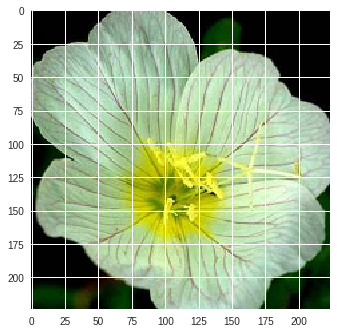

In [0]:
imshow(tmp)

## Class Prediction

Once you can get images in the correct format, it's time to write a function for making predictions with your model. A common practice is to predict the top 5 or so (usually called top-$K$) most probable classes. You'll want to calculate the class probabilities then find the $K$ largest values.

To get the top $K$ largest values in a tensor use [`x.topk(k)`](http://pytorch.org/docs/master/torch.html#torch.topk). This method returns both the highest `k` probabilities and the indices of those probabilities corresponding to the classes. You need to convert from these indices to the actual class labels using `class_to_idx` which hopefully you added to the model or from an `ImageFolder` you used to load the data ([see here](#Save-the-checkpoint)). Make sure to invert the dictionary so you get a mapping from index to class as well.

Again, this method should take a path to an image and a model checkpoint, then return the probabilities and classes.

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

In [0]:
class_to_idx = image_datasets['train'].class_to_idx
idx_to_class = {v: k for k, v in class_to_idx.items()}

In [0]:
def predict(image_path, model, topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    image = process_image(image_path)
    image.unsqueeze_(0) # add batch dimension
    
    model.eval()
    # model = model.to('cpu')
    
    with torch.no_grad():
        output = F.softmax(model(image), dim=1)
        probs, labels = torch.topk(output, topk)
    
    # TODO: Implement the code to predict the class from an image file
    return probs.numpy()[0], np.array([idx_to_class[i] for i in labels.numpy()[0]])



# def evaluate_model(model=model, data=dataloaders['val'], 
#                    title='Confusion matrix', normalize=False,
#                   labels_=labels_, target_names=target_names):
#     y_true = []
#     y_pred = []
    
#     # first, get the predictions
#     model.eval() # set model in evaluation mode
#     with torch.no_grad():
#         # Iterate over data.
#         for inputs, labels in data:
#             # inputs = inputs.to(device, dtype=torch.float)
#             inputs = inputs.to(device, dtype=torch.float)
#             y_true.append(labels.squeeze(1))
#             labels = labels.view(labels.size()[0]).to(device)
#             outputs = model(inputs)
#             _, preds = torch.max(outputs, 1)
#             y_pred.append(preds.to('cpu').numpy())
            
#     # print classification report
#     y_true, y_pred = np.concatenate(y_true), np.concatenate(y_pred)
#     print(classification_report(y_true, y_pred, labels=labels_, target_names=target_names))
    
#     # plot the confusion matrix
#     cm = confusion_matrix(y_true, y_pred)
    
#     accuracy = np.trace(cm) / float(np.sum(cm))
#     misclass = 1 - accuracy

#     cmap = plt.get_cmap('Blues')

#     plt.figure(figsize=(8, 6))
#     plt.imshow(cm, interpolation='nearest', cmap=cmap)
#     plt.title(title)
#     plt.colorbar()

#     tick_marks = np.arange(len(target_names))
#     plt.xticks(tick_marks, target_names, rotation=45)
#     plt.yticks(tick_marks, target_names)

#     if normalize:
#         cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
        
#     thresh = cm.max() / 1.5 if normalize else cm.max() / 2
#     for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
#         if normalize:
#             plt.text(j, i, "{:0.4f}".format(cm[i, j]),
#                      horizontalalignment="center",
#                      color="white" if cm[i, j] > thresh else "black")
#         else:
#             plt.text(j, i, "{:,}".format(cm[i, j]),
#                      horizontalalignment="center",
#                      color="white" if cm[i, j] > thresh else "black")

#     plt.tight_layout()
#     plt.ylabel('True label')
#     plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
#     plt.show()


In [0]:
path = './flower_data/valid/1/image_06739.jpg'
probs, labs = predict(path, model_resnet_loaded)
print(probs)
print(labs)

[8.9812475e-01 9.1024108e-02 9.6508944e-03 4.7530505e-04 2.9716527e-04]
['1' '86' '12' '19' '48']


In [0]:
path = './flower_data/valid/17/image_03839.jpg'
probs, labs = predict(path, model_resnet_loaded)
print(probs)
print(labs)

[0.9458328  0.04479209 0.00253478 0.00230747 0.00148567]
['17' '100' '82' '71' '49']


## Sanity Checking

Now that you can use a trained model for predictions, check to make sure it makes sense. Even if the validation accuracy is high, it's always good to check that there aren't obvious bugs. Use `matplotlib` to plot the probabilities for the top 5 classes as a bar graph, along with the input image. It should look like this:

<img src='assets/inference_example.png' width=300px>

You can convert from the class integer encoding to actual flower names with the `cat_to_name.json` file (should have been loaded earlier in the notebook). To show a PyTorch tensor as an image, use the `imshow` function defined above.

In [0]:
torch.save(model_resnet_loaded.state_dict(), './resnet_model.pth')


In [0]:
from google.colab import files
files.download('./resnet_model.pth')


In [0]:
# TODO: Display an image along with the top 5 classes